# U-net Denoising demo

Notebook containing all work relevant to creating a neural network based denoising pipeline. The notebook contains each of the following steps:


6. Model Design
7. Model Training
8. Results Analysis
9. Appendix

## 0. Setup
This section is for importing libraries and defining paths

### 0.a - Cloud Training
Set the below boolean to true if the code is being run on Rice's cloud clusters

In [1]:
on_cloud = False # !impt

### 0.b - Imports

In [2]:
# import libraries
from time import time
from copy import deepcopy
from heart_utils import *

import random
import librosa
import numpy as np
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# reproducibility
seed = 777 # three lucky numbers
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)
# this should take care of reproducibility in sklearn too
# (see https://sklearn-genetic-opt.readthedocs.io/en/stable/tutorials/reproducibility.html)

# if training on cloud
if on_cloud: # !impt (only if you're on Rice's clusters): set these. Run nvidia-smi and top first, also check spreadsheet
  device_str = '1' # should change often
  threads_str = '2' # shouldn't
  os.environ['CUDA_VISIBLE_DEVICES'] = device_str
  os.environ['OMP_NUM_THREADS'] = threads_str
  os.environ['CUBLAS_WORKSPACE_CONFIG']=":4096:8"

### 0.c - Paths

In [3]:
# for cloud compute vs local running
if torch.cuda.is_available(): # i.e. if not running on my macbook
  # !impt: ^ the assumption is that the non-cloud device doesn't have cuda (this is the case for me)
  prepend = '/mnt/data1/emz1/heart/datasets/'
  split_dir = '/mnt/data1/emz1/heart/splits/'
  model_dir = '/mnt/data1/emz1/heart/models/'

else:
  prepend = '/Users/donu/Desktop/semesters/S25/ELEC 594/datasets/'
  split_dir = '/Users/donu/Desktop/semesters/S25/ELEC 594/storage/'
  model_dir = '/Users/donu/Desktop/semesters/S25/ELEC 594/storage/' # not a typo

prepend

'/Users/donu/Desktop/semesters/S25/ELEC 594/datasets/'

In [4]:
## Dirs
# physio22/circor dataset
physio22_path = prepend+'physio22/'
# the bentley dataset is the clean PCG dataset from the U-net paper
pascal_dset_path = prepend+'pascal-dset/'

In [5]:
arcalabels_path = prepend+'ARCA23K_ground_truth/'
# the arcawavs directory contains the real world noise data from the ARCA23K dataset
arcawavs_path = prepend+'ARCA23K_audio/'
# hospital ambient sounds dataset, from the Ali paper
han_raw_path = prepend+'hospital-noise-original/'
han_filtered_path = prepend+'hospital-noise-filtered-resampled/'
# OAHS/physionet '16
physio16_path = prepend+'physio16/'
physio_anno_path = physio16_path +'annotations/Online_Appendix_training_set.csv'
# ESC50 dataset
esc50_path = prepend+'ESC-50/'
esc50_anno_path = esc50_path + 'meta/esc50.csv'


In [6]:
# relevant paths for where things will be stored
train_inputs_loc = split_dir+'training_inputs.dat'
val_inputs_loc = split_dir+'val_inputs.dat'
test_inputs_loc = split_dir+'test_inputs.dat'
# # outputs
train_outputs_loc = split_dir+'training_outputs.dat'
val_outputs_loc = split_dir+'val_outputs.dat'
test_outputs_loc = split_dir+'test_outputs.dat'
# # metadata
train_meta_loc = split_dir+'training_meta.dat'
val_meta_loc = split_dir+'val_meta.dat'
test_meta_loc = split_dir+'test_meta.dat'

# also initialize path where metadata for full-length PCGs is stored as csv
save_path_metadata = split_dir+'metadata.csv'
# and where memmap dimension data will be stored
save_path_info = split_dir+"general_info.json"

### 0.d - Load dataset

In [7]:
# !impt: general metadata from dataset creation step
with open(save_path_info, 'r') as f:
    general_info = json.load(f)
general_info

{'training_input_output_dims': [2544560, 1600],
 'val_input_output_dims': [371760, 1600],
 'test_input_output_dims': [748976, 1600],
 'training_metadata_dims': [2544560, 6],
 'val_metadata_dims': [371760, 6],
 'test_metadata_dims': [748976, 6],
 'segment_length': 1600,
 'target_freq': 2000,
 'snr_db': [-3, 0, 3, 6],
 'num_noises': [2, 0, 2],
 'seconds_per_segment': 0.8,
 'metadata_shape': 6,
 'memmap_type': 'float32',
 'weights': {'1': 3.99565348474951, '0': 0.5715173861169808}}

In [8]:
memmap_type = general_info["memmap_type"]
in_out_shape_training = tuple(general_info["training_input_output_dims"])
in_out_shape_val = tuple(general_info["val_input_output_dims"])
in_out_shape_test = tuple(general_info["test_input_output_dims"])
meta_shape_training = tuple(general_info["training_metadata_dims"])
meta_shape_val = tuple(general_info["val_metadata_dims"])
meta_shape_test = tuple(general_info["test_metadata_dims"])

# load inputs
train_inputs = np.memmap(train_inputs_loc, dtype=memmap_type, mode='r', shape = in_out_shape_training)
val_inputs = np.memmap(val_inputs_loc, dtype=memmap_type, mode='r', shape = in_out_shape_val)
test_inputs = np.memmap(test_inputs_loc, dtype=memmap_type, mode='r', shape = in_out_shape_test)
# load outputs
train_outputs = np.memmap(train_outputs_loc, dtype=memmap_type, mode='r', shape = in_out_shape_training)
val_outputs = np.memmap(val_outputs_loc, dtype=memmap_type, mode='r', shape = in_out_shape_val)
test_outputs = np.memmap(test_outputs_loc, dtype=memmap_type, mode='r', shape = in_out_shape_test)
# load meta
train_meta = np.memmap(train_meta_loc, dtype=memmap_type, mode='r', shape = meta_shape_training)
val_meta = np.memmap(val_meta_loc, dtype=memmap_type, mode='r', shape = meta_shape_val)
test_meta = np.memmap(test_meta_loc, dtype=memmap_type, mode='r', shape = meta_shape_test)

## 6 - Model Architecture

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f'Device: {device}')

Device: mps


### 6.a - Create Batches with DataLoader

In [10]:
class PCG_Dataset(Dataset):
    def __init__(self, inputs, outputs, metadata,device = device):
        # making them an np.array speeds up the conversion process to tensor
        # below code no longer viable though, due to memmap use
        #inputs = np.array(inputs) # inputs is expected to be a list of np vectors
        #outputs = np.array(outputs) # outputs is expected to be a list of np vectors
        #metadata = np.array(metadata)
        
        self.inputs = inputs  # Ensure tensor format
        self.outputs = outputs
        self.metadata = metadata
        self.device = device
    def __len__(self):
        return max(len(self.inputs),len(self.outputs)) # will eventually throw an error if the sizes aren't matched

    def __getitem__(self, idx):
        # expectation is (batch_size, channels, datalen) in torch
        x = self.inputs[idx][np.newaxis, :]  # Add channel dim
        y = self.outputs[idx][np.newaxis, :]
        meta = self.metadata[idx]
        # send to cuda/mps
        x_tensor = torch.tensor(x, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.float32).to(self.device)
        meta_tensor = torch.tensor(meta, dtype=torch.float32).to(self.device)
        return x_tensor, y_tensor, meta_tensor

In [11]:
training_data_raw = PCG_Dataset(train_inputs,train_outputs,train_meta,device) # i think that
val_data_raw = PCG_Dataset(val_inputs,val_outputs,val_meta,device)
test_data_raw = PCG_Dataset(test_inputs,test_outputs,test_meta,device)

In [12]:
def make_batch(dataset,batchsize):
  """
  Creating batches
  """
  dataloader = DataLoader(
  	dataset,
    batch_size=batchsize, shuffle=True
)
  return dataloader

### 6.b - Optimizers

#### 6.b.1 - Schedulers

In [13]:
# linear warmup + cosine decay
dset_size = len(train_inputs)
def linear_warmup_cosine_annealing(model,base_lr,batch_size,num_examples=dset_size,cos_period=6,start_factor=0.1,warmup_epochs=2):
  """
  Creates a cosine annealing scheduler with linear warmup
  
  Inputs:
  - model: The model to optimize
  - base_lr: Base learning rate
  - batch_size: What batch size the optimizer will be used with
  - num_examples: Size of training dataset
  - cos_period: How many epochs an annealing period lasts
  - start_factor: Number in [0,1], the starting multiplier for linear warmup
  - warmup_epochs: Positive integer, the number of epochs to warm up for
  
  Returns optimizer and scheduler for optimizer
  """
  optim = torch.optim.AdamW(model.parameters(),lr=base_lr)
  
  # algebra
  steps_per_epoch = num_examples/batch_size
  warmup_len = int(warmup_epochs*steps_per_epoch)
  annealing_len = int(cos_period*steps_per_epoch)
  
  # linear warmup
  linear_warmup = torch.optim.lr_scheduler.LinearLR(optim,
                                                    start_factor=start_factor,
                                                    total_iters=warmup_len
                                                    )
  # cosine annealing
  cos_annealing = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim,annealing_len)
  
  # overall scheduler
  scheduler = torch.optim.lr_scheduler.SequentialLR(optim,schedulers=[linear_warmup, cos_annealing],milestones=[warmup_len])
  
  return optim, scheduler

### 6.c - Models

#### 6.c.1 - Building Blocks

In [14]:
# some useful building blocks for the full U-Net and maybe future models

# Encoder Block
class EncoderBlock(nn.Module):
  def __init__(self,in_layers,out_layers,k_size):
    super().__init__()

    self.architecture = nn.Sequential(nn.Conv1d(in_layers,out_layers,k_size,padding='same'),
                              nn.BatchNorm1d(out_layers), # testing BatchNorm now
                              nn.GELU(), # testing GELU now
                              nn.Conv1d(out_layers,out_layers,k_size,padding='same'),
                              nn.BatchNorm1d(out_layers),
                              nn.GELU())
  # change forward behavior based on input count
  def forward(self,x):
    return self.architecture(x)
# Decoder block
class DecoderBlock(nn.Module):
  def __init__(self,in_layers,out_layers,k_size): # in_layers being the amount of in layers ignoring concat
    super().__init__()
    # some sleight of hand tricks here:
    mid_layers = in_layers 
    in_layers = in_layers*2 # you must accomodate concatenation
    # overall, the progression would be like (512->256->128)
    # proceeding
    self.architecture = nn.Sequential(nn.Conv1d(in_layers,mid_layers,k_size,padding='same'),
                              nn.BatchNorm1d(mid_layers), # testing BatchNorm now
                              nn.GELU(), # testing GELU now
                              nn.Conv1d(mid_layers,out_layers,k_size,padding='same'),
                              nn.BatchNorm1d(out_layers),
                              nn.GELU())
  # change forward behavior based on input count
  def forward(self,x,y):
      dim = len(x.shape)-2 # if unbatched, shape is (channels,datalen). if batched, (batches,channels,datalen)
      # concatenate among channels
      z = torch.cat([x,y],dim=dim)
      return self.architecture(z)
# down or up sample
class Level_Change(nn.Module):
  def __init__(self,direction):
    super().__init__()
    if direction=='down':
      self.architecture = nn.MaxPool1d(2)
    if direction=='up': # somehow, linear upsampling isn't deterministic in torch. will have to use nearest...
      self.architecture = nn.Upsample(scale_factor=2,mode='nearest') # 
    
  def forward(self,x):
    return self.architecture(x)
  
# bottleneck layer
class BottleNeck(nn.Module):
    def __init__(self,in_layers,k_size):
      super().__init__()
      out_layers = in_layers*2
      self.architecture = nn.Sequential(nn.Conv1d(in_layers,out_layers,k_size,padding='same'),
                                        nn.BatchNorm1d(out_layers),
                                        nn.GELU(),
                                        nn.Conv1d(out_layers,in_layers,k_size,padding='same'),
                                        nn.BatchNorm1d(in_layers),
                                        nn.GELU())
    def forward(self,x):
      return self.architecture(x)

# the final convolution block
class FinalConv(nn.Module):
  def __init__(self,in_layers, k_size):
    super().__init__()
    self.architecture = nn.Sequential(nn.Conv1d(in_layers,1,k_size,padding='same'),
                                      nn.Tanh())
  def forward(self,x):
    return self.architecture(x)

#### 6.c.2 - U-Net Lite

In [15]:
class Lite_UNet(nn.Module):
  def __init__(self):
    super().__init__()
    # model architecture
    # encoder, lvl 1
    self.conv_1 = nn.Conv1d(1,16,31,padding = 'same')
    self.relu_1 = nn.ReLU()
    
    # encoder, lvl 2
    self.conv_2 = nn.Conv1d(16,32,31,stride = 2,padding = 15)
    self.relu_2 = nn.ReLU()

    # encoder, lvl 3
    self.conv_3 = nn.Conv1d(32,32,31,stride = 2,padding = 15)
    self.relu_3 = nn.ReLU()

    # encoder, lvl 4
    self.conv_4 = nn.Conv1d(32,64,31,stride = 2,padding = 15)
    self.relu_4 = nn.ReLU()

    # encoder, lvl 5
    self.conv_5 = nn.Conv1d(64,64,31,stride = 2,padding = 15)
    self.relu_5 = nn.ReLU()

    # bottleneck
    self.bottleneck = nn.Conv1d(64,128,31,stride = 2,padding = 15)
    self.relu_bottleneck = nn.ReLU()
    
    # decoder, lvl 5
    self.conv_6 = nn.Conv1d(128,64,31,padding = 'same')
    self.relu_6 = nn.ReLU()
    self.upsample_1 = nn.Upsample(scale_factor = 2)
    
    # decoder, lvl 4
    self.conv_7 = nn.Conv1d(64,64,31,padding = 'same')
    self.relu_7 = nn.ReLU()
    self.upsample_2 = nn.Upsample(scale_factor = 2)
    
    # decoder, lvl 3
    self.conv_8 = nn.Conv1d(64,32,31,padding = 'same')
    self.relu_8 = nn.ReLU()
    self.upsample_3 = nn.Upsample(scale_factor = 2)
    
    # decoder, lvl 2
    self.conv_9 = nn.Conv1d(32,32,31,padding = 'same')
    self.relu_9 = nn.ReLU()
    self.upsample_4 = nn.Upsample(scale_factor = 2)
    
    # decoder, lvl 1
    self.conv_10 = nn.Conv1d(32,16,31,padding = 'same')
    self.relu_10 = nn.ReLU()
    self.upsample_5 = nn.Upsample(scale_factor = 2) 
    
    # end
    self.conv_final = nn.Conv1d(16,1,31,padding = 'same')
    self.tanh_final = nn.Tanh() # makes sense, since input is in [-1,1]
    
  # possible improvements: batch norm, gelu
  def forward(self,x):
    res = self.conv_1(x)
    res = self.relu_1(res)

    res = self.conv_2(res)
    res = self.relu_2(res)

    res = self.conv_3(res)
    res = self.relu_3(res)

    res = self.conv_4(res)
    res = self.relu_4(res)

    res = self.conv_5(res)
    res = self.relu_5(res)
   
    res = self.bottleneck(res)
    res = self.relu_bottleneck(res)
    
    res = self.conv_6(res)
    res = self.relu_6(res)
    res = self.upsample_1(res)
    
    res = self.conv_7(res)
    res = self.relu_7(res) 
    res = self.upsample_2(res)

    res = self.conv_8(res)
    res = self.relu_8(res) # bruh
    res = self.upsample_3(res)
    
    res = self.conv_9(res)
    res = self.relu_9(res) 
    res = self.upsample_4(res)
    
    res = self.conv_10(res)
    res = self.relu_10(res)
    res = self.upsample_5(res)
    
    res = self.conv_final(res)
    res = self.tanh_final(res)
    
    return res

#### 6.c.3 - Full U-Net

In [16]:
class U_Net(nn.Module):
  def __init__(self):
    super().__init__()
    # level 1 - decoder
    self.down1 = EncoderBlock(1,32,63) # a stride of 63 captures about 30ms of heartbeat 
    self.downlvl1 = Level_Change('down')
    
     # level 2 - decoder
    self.down2 = EncoderBlock(32,64,31)
    self.downlvl2 = Level_Change('down')
    
     # level 3 - decoder
    self.down3 = EncoderBlock(64,128,15)
    self.downlvl3 = Level_Change('down')
    
     # level 4 - decoder
    self.down4 = EncoderBlock(128,256,9)
    self.downlvl4 = Level_Change('down')
    
    # bottleneck
    self.lvl5 = BottleNeck(256,15) # bottleneck
    self.uplvl4 = Level_Change('up')
    
    # level 4 - encoder
    self.up4 = DecoderBlock(256,128,9)
    self.uplvl3 = Level_Change('up')
    
    # level 3 - encoder
    self.up3 = DecoderBlock(128,64,15)
    self.uplvl2 = Level_Change('up')
    
    # level 2 - encoder
    self.up2 = DecoderBlock(64,32,31)
    self.uplvl1= Level_Change('up')
    
    # level 1 - encoder
    self.up1 = DecoderBlock(32,32,63)
    
    # final convolution
    self.finalconv = FinalConv(32,3) # kernel of 3 for a bit of smoothing
    
  def forward(self,x):
    # decoder blocks
    x1 = self.down1(x)
    #print(x1.shape)
    x2 = self.down2(self.downlvl1(x1))
    #print(x2.shape)
    x3 = self.down3(self.downlvl2(x2))
    #print(x3.shape)
    x4 = self.down4(self.downlvl3(x3))
    #print(x4.shape)
    x_we = self.downlvl4(x4) 
    # bottleneck
    xbn = self.lvl5(x_we)
    # enconder blocks
    x = self.up4(self.uplvl4(xbn),x4) 
    #print(x.shape)
    x = self.up3(self.uplvl3(x),x3)
    #print(x.shape)
    x = self.up2(self.uplvl2(x),x2)
    #print(x.shape)
    x = self.up1(self.uplvl1(x),x1)
    #print(x.shape)
    
    # final conv
    x = self.finalconv(x)
    #print(x.shape)
    return x

In [17]:
# !impt: Select model to train/test, and define relevant hyperparams
model = U_Net().to(device) 
lossfunc = nn.MSELoss(reduction='none')

# batch size
base_bs = 32
base_lr = 1e-5 # this rate was pretty good
if device.type =='cuda': # assuming this means you're on Rice's cloud GPUs
  batch_size = 2048 # can set batch size quite high. could set it to >1M actually
else:
  batch_size = 64

# linear scaling rule
lr = base_lr*round(batch_size/base_bs)
print(f"{'Model Class':<15}{ type(model).__name__}")
print(f"{'Batch Size:':<15}{batch_size}")
print(f"{'Learning Rate:':<15}{lr:.5f}")
# optimizer + scheduler
optimizer, scheduler = linear_warmup_cosine_annealing(model,lr,batch_size,num_examples=dset_size,cos_period=12,start_factor=0.1,warmup_epochs=2) # way more params defined above

Model Class    U_Net
Batch Size:    64
Learning Rate: 0.00002


## 7 - Model Training

### 7.a - Train/Validation/Test split

In [18]:
train_data = make_batch(training_data_raw,batch_size) # shuffles them too
val_data = make_batch(val_data_raw,batch_size)
test_data = make_batch(test_data_raw,batch_size)

### 7.b - Training

In [19]:
def val_acc_w_uw(model,val_data):
  """
  Calculates class-weighted and unweighted validation accuracy
  
  Returns class-weighted and unweighted validation accuracy, in that order
  """
  model.eval()
  with torch.no_grad():
    total_loss_uw, total_loss_w = 0,0
    for i, (inputs, labels, meta) in enumerate(val_data):
      # evaluate
      outputs = model(inputs)
      # calculate losses
      raw_loss = lossfunc(outputs,labels).mean(dim=[1,2]) # (MSE for each item in batch)
      # unweighted loss
      loss_uw = raw_loss.mean().item()
      # weighted loss
      has_murmur = meta[:,2].int()
      weights = torch.Tensor([cwl_weights[murm.item()] for murm in has_murmur]).to(device)
      loss_w = (raw_loss*weights).mean().item()
      # add
      total_loss_uw += loss_uw
      total_loss_w += loss_w
      
    return total_loss_w/(i+1),total_loss_uw/(i+1) # return average loss per batch
  

In [20]:
def plot_losses(training_losses,val_losses_uw, val_losses_w):
  plt.plot(training_losses, label='Training Loss',c='g')
  plt.plot(val_losses_uw, label='Validation Loss (unweighted)',c='y')
  plt.plot(val_losses_w, label='Validation Loss (weighted)', c='tab:purple')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title("Training vs Validation Loss")
  plt.ylim([0,1.1*max(max(training_losses),max(val_losses_uw),max(val_losses_w))])
  plt.legend()
  plt.show()

In [21]:
if isinstance(model, Lite_UNet):
  save_location = model_dir+"pseudo_unet.pth"
elif isinstance(model, U_Net):
  save_location = model_dir+"full_unet.pth"

In [22]:
%%script false --no-raise-error 
### ^ If un-commented, cell is disabled. (This cell is used for training the model)
# !impt: be sure to back up any old models you want to keep when you run this cell

PATIENCE = 3 # Num epochs before early stopping (int)
# Hyperparams
NUM_EPOCHS = 40 # Max num epochs to train for
RATIO_CUTOFF = 0.85 # amount training loss can be less than val loss by
OVERFIT_CUTOFF = 1.05 # amount val loss is allowed to increase by
# ^ honestly kind of redundant now b/c of patience but no harm either
cwl_weights = general_info["weights"] # class weights for weighted loss
cwl_weights[0], cwl_weights[1] = cwl_weights['0'], cwl_weights['1']


# simple variables
patience = int(PATIENCE) # making sure
starttime = time() # unix time at which training begun
min_val = float("inf") # lowest val loss 

# losses
training_losses = []
val_losses_weighted = []
val_losses_unweighted = []
# training loop
for epoch in range(NUM_EPOCHS):
  # reset loss per epoch
  running_loss = 0
  epoch_stime = time()
  model.train()
  for idx, (inputs, labels, meta) in enumerate(train_data):
    
    # Reset gradients per batch
    optimizer.zero_grad()

    # Predict
    outputs = model(inputs)

    # Class weighted learning
    has_murmur = meta[:,2].int()
    weights = torch.Tensor([cwl_weights[murm.item()] for murm in has_murmur])
    weights = weights.to(device)

    # Compute the loss and its gradients
    raw_loss = lossfunc(outputs, labels).mean(dim=[1,2])
    loss = (raw_loss*weights).mean()
    loss.backward()
  
    # Adjust learning weights
    optimizer.step()
    scheduler.step()

    # Gather data and report
    running_loss += loss.item()
  
  # keep track of training loss
  loss_this_epoch = running_loss/(idx+1)
  training_losses.append(loss_this_epoch)
  # keep track of val loss
  val_loss_w, val_loss_uw = val_acc_w_uw(model,val_data)
  val_losses_weighted.append(val_loss_w)
  val_losses_unweighted.append(val_loss_uw)
  # the losses are averages by the way
  print(f"Epoch: {epoch} | Training Loss: {loss_this_epoch:.4f} | Val Loss (W,UW): ({val_loss_w:.4f},{val_loss_uw:.4f})| LR: {optimizer.param_groups[0]['lr']:.2e}| Time: {time()-epoch_stime:.0f}s")
  # store the parameters of the model with the lowest validation loss
  if val_loss_w <min_val: # !impt: Use weighted val loss, since we care much about murmur denoising performance
    best_model_state = deepcopy(model.state_dict()) # not sure if deepcopy does anything. but for that one 447 HW...
    optim_state = deepcopy(optimizer.state_dict())
    patience = PATIENCE
  else:
    patience -= 1
  # check for indirect overfitting
  if patience == 0:
    print(f"Validation loss has not improved in {PATIENCE} epochs. Exiting to avoid overfitting")
    break
  if loss_this_epoch<RATIO_CUTOFF*val_loss_w:
    print(f"Training loss is less than {int(100*RATIO_CUTOFF)}% of validation loss. Exiting!")
    break
  # check for direct overfitting
  if val_loss_w>OVERFIT_CUTOFF*min_val:
    print(f"Validation loss is more than {int(100*(OVERFIT_CUTOFF-1))}% of its minimum. Exiting to avoid overfitting")
    break
  if epoch == NUM_EPOCHS-1:
    print(f"Reached epoch limit. Exiting")
    break
  # store minimum validation loss
  min_val = min(min_val,val_loss_w)

print(f"Model finished training. Total time: {int((time()-starttime)/60)}min {int(time()-starttime)%60}sec")

torch.save({'model':best_model_state,
            'optimizer':optim_state}, save_location)
print(f"Model saved to {save_location}")
plot_losses(training_losses,val_losses_unweighted,val_losses_weighted) # yikes!
#!impt: persistent, bizarre tendency, across all seeds, where val loss is much less than training loss
# # why? you should know and investigate this

In [23]:
# problem: training loss is completely flat
# - take notes about all these things in notion
# - note: these numbers are consistent with no training whatsoever
# things
# # 0. confirm that the inputs/outputs are actually correct (don't load them)
# # 1. might like to save the training and test data. also be sure that they're legit
# # 2. rewind this repo to the time where the loss was actually decreasing
# # 3. modify the learning rate
# # 4. try leaky relu or similar
# # 5. ask da homie for advice

# SOLN: the training rate was too high. oscillatory behavior then? idk.

## 8 - Measuring model performance

In [24]:
# loading the model
model_loaded = torch.load(save_location,map_location=device,weights_only=True)
model.load_state_dict(model_loaded['model'])
# Loading the optimizer (generally useless)
#optimizer_loaded = torch.optim.Adam(model.parameters(),lr=2e-5)
#optimizer_loaded.load_state_dict(model_loaded['optimizer'])

<All keys matched successfully>

### 8.a - Metrics for model performance

In [25]:
# i moved most of these functions to step 5
# but in sum there are:
# # avg_power
# # rmse_calc
# # snr_calc

In [26]:
avg_power(np.array([3,3,3,3,3,3]))

9.0

In [27]:
rmse(np.array([1,2,3]),np.array([0,1,2]))

1.0

### 8.b - Testing model performance on test data

In [28]:
# outline of what to do
# 1. iterate over the test data
# 2. run model on it (eval only)
# 3. generate RMSE/SNR metrics for the original clean/noisy pair
# 4. generate RMSE/SNR metrics for the original clean and denoised pair
# 5. store these somewhere for alter visualization

11703

In [31]:
# model performance on test data
pct_num = len(test_data)//100
orig_snrs = []
orig_rmses = []

denoised_snrs = []
denoised_rmses = []
# evaluate model on test data
mdata_per_seg = []
with torch.no_grad():
  model.eval()
  for idx, (inputs, labels, metadata) in enumerate(test_data): #
    
    # extract composite, reference and metadata
    noisy = inputs.cpu().detach().numpy()
    clean = labels.cpu().detach().numpy()
    metadata = metadata.cpu().detach().numpy() # [0] is the mval, [1] is the snr, [2] is the murmur presence
  
    # get outputs and detach
    outputs = model(inputs)
    denoised = outputs.cpu().detach().numpy() 
    for dpoint_idx in range(len(noisy)): # calculate snr and such per sample
      local_noisy = noisy[dpoint_idx]
      local_clean = clean[dpoint_idx]
      local_denoised = denoised[dpoint_idx]
      local_mdata = metadata[dpoint_idx]
      # steps for SNR calc
      mval = local_mdata[0]
      scaled_clean = local_clean # PCG scaling now applies to 100% of clean recordings. thus this.
      #fullsized_noisy = local_noisy*mval# for snr calculations, want to recover orig recording
      # snr and rmse
      # # for snr, want to extract original noise and compare it to original signal 
      #snr_noisy = snr_calc(scaled_clean,fullsized_noisy)
      #snr_denoised = snr_calc(scaled_clean,local_denoised)
      # # for rmse, just measure distance of both regardless of scale
      rmse_noisy = rmse(scaled_clean,local_noisy)
      rmse_denoised = rmse(scaled_clean,local_denoised)
      # add to arrays
      #orig_snrs.append(snr_noisy)
      orig_rmses.append(rmse_noisy)
      #denoised_snrs.append(snr_denoised)
      denoised_rmses.append(rmse_denoised)
      mdata_per_seg.append(local_mdata)
      #print(f'Noisy SNR: {snr_noisy}, Denoised SNR: {snr_denoised}')
      #print(f'Noisy RMSE: {rmse_noisy}, Denoised RMSE: {rmse_denoised}')

    if idx%pct_num==0:
      print(f"Completed {idx//pct_num}% of test data")
# better to have them as np array. makes sorting easier
#orig_snrs = np.array(orig_snrs)
orig_rmses = np.array(orig_rmses)
#denoised_snrs = np.array(denoised_snrs)
denoised_rmses = np.array(denoised_rmses)
# note that there are several occassions when the feature and label pairs given to the model are the same
# this means that you should adjust for SNR=inf (index these and remove)
# divide by zero errors to be expected as a result (noise power is 0 in these cases)

Completed 0% of test data
Completed 1% of test data
Completed 2% of test data


KeyboardInterrupt: 

### 8.c - Derived Metrics

In [ ]:
# % of times denoised rmse is less than original rmse
def calc_denoised_rmse_better_pct(denoised, orig):
    denoised_rmse_better = np.sum(denoised < orig) / len(orig)
    return np.round(denoised_rmse_better,3)

def histogram_for_metric(denoised, orig, metric_name, bins=30):
    plt.figure(figsize=(10, 6))
    plt.hist(orig, bins=bins, alpha=0.5, label='Original', color='blue', edgecolor='black')
    plt.hist(denoised, bins=bins, alpha=0.5, label='Denoised', color='orange', edgecolor='black')
    plt.xlabel(metric_name)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {metric_name} for Original vs Denoised Signals')
    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.show()
    


In [ ]:
# remove the SNRs thar are float inf or otherwise reeeeally high
not_infs = orig_snrs<1e3
sum(not_infs)/len(orig_snrs) #pct of subrecordings without reeeally high snr

0.9859977121988078

In [ ]:
# discard for metrics (even one inf value will mess up metrics)
orig_snrs = orig_snrs[not_infs]
denoised_snrs = denoised_snrs[not_infs]
# don't want to do this for rmse though. should keep track of how the model performs for very clean data
#orig_rmses = orig_rmses[not_infs]
#denoised_rmses = denoised_rmses[not_infs]

In [ ]:
# very simple analysis # now this is actually accurate
print(f"RMSE min/mean/max of noisy data: {np.min(orig_rmses):.3f},{np.mean(orig_rmses):.3f},{np.max(orig_rmses):.3f}")
print(f"RMSE min/mean/max of denoised data: {np.min(denoised_rmses):.3f},{np.mean(denoised_rmses):.3f},{np.max(denoised_rmses):.3f}")
meanimp_rmse = 100*(np.mean(denoised_rmses)-np.mean(orig_rmses))/np.mean(orig_rmses)
print(f"Mean noise reduction: {np.abs(meanimp_rmse):.1f}%")

RMSE min/mean/max of noisy data: 0.000,0.080,0.439
RMSE min/mean/max of denoised data: 0.003,0.043,0.463
Mean noise reduction: 46.5%


In [ ]:
%%script false --no-raise-error # snr calc is so confusing. commenting out until i figure out how this works
# very simple analysis
# calculating snr is very confusing, esp b/c noise can be very concentrated or sparse for the subsegments
# SNR values with very high magnitude will this be common no matter what...
meandiffsnr = np.mean(denoised_snrs)-np.mean(orig_snrs)
signsnr = '+' if meandiffsnr>=0 else ''

print(f"SNR min/mean/max of noisy data: {np.min(orig_snrs):.3f},{np.mean(orig_snrs):.3f},{np.max(orig_snrs):.3f}") # this really shouldn't be the case. what?
print(f"SNR min/mean/max of denoised data: {np.min(denoised_snrs):.3f},{np.mean(denoised_snrs):.3f},{np.max(denoised_snrs):.3f}")
print(f"Mean SNR improvement: {signsnr}{np.mean(denoised_snrs)-np.mean(orig_snrs):.3f}dB")

In [ ]:
# Notes at this point:
# # Mean SNR should be ~1.5, since that is the avg of [-3,0,3,6], the reference SNR values. 
# # # The fact that this is not the case may suggest a bug in the creation of the synthetically noisy data
# # # (Double check )
# These results are basically very bad. Average RMSE is flat. SNR improvement is +0.3. Things to check:
# # 1. The data
# # # a. Visualize the "clean" pascal recordings. See what's up. 
# # # b. First, inspect the data qualitatively (listen to the combined sounds)
# # # c. Check if the SNR of the segments actually make sense

### 8.c - Test model performance on full pascal dataset

In [ ]:
full_pascal_performances = {'normal':{'orig_snr':[],'orig_rmse':[],'new_snr':[],'new_rmse':[]},
                            'murmur':{'orig_snr':[],'orig_rmse':[],'new_snr':[],'new_rmse':[]}}


### 8.d  - Visualizing model performance on PhysioNet '16

### 8.d.1 - Load the OAHS (Physionet '16) dataset

In [ ]:
# might use these again
normal_str_16 = "Class (-1=normal 1=abnormal)"
murmur_str_16 = "Murmurs (2=None 3=Weak 4=Strong 6=Unclear)"

In [ ]:
# the paths to each of the good normal PCG recordings. these were found in the other ipynb
normal_path_1 = physio16_path + 'training-a/a0045.wav'
normal_path_2 = physio16_path + 'training-a/a0027.wav'
normal_path_3 = physio16_path + 'training-a/a0127.wav'

# the paths to the good murmured heartbeat recordings.
murmur_path_1 = physio16_path + 'training-b/b0197.wav'
murmur_path_2 = physio16_path + 'training-b/b0030.wav'

In [ ]:
# load each of these recordings
normal_rec_1, sr_physio16 = load_from_filepath(normal_path_1) # the sr is the same for all recordings
normal_rec_2 = load_from_filepath(normal_path_2)[0]
normal_rec_3 = load_from_filepath(normal_path_3)[0]
# for murmurs too
murmur_rec_1 = load_from_filepath(murmur_path_1)[0]
murmur_rec_2 = load_from_filepath(murmur_path_2)[0]

[Text(0.5, 1.0, 'Murmur PCG 2 (b0030)')]

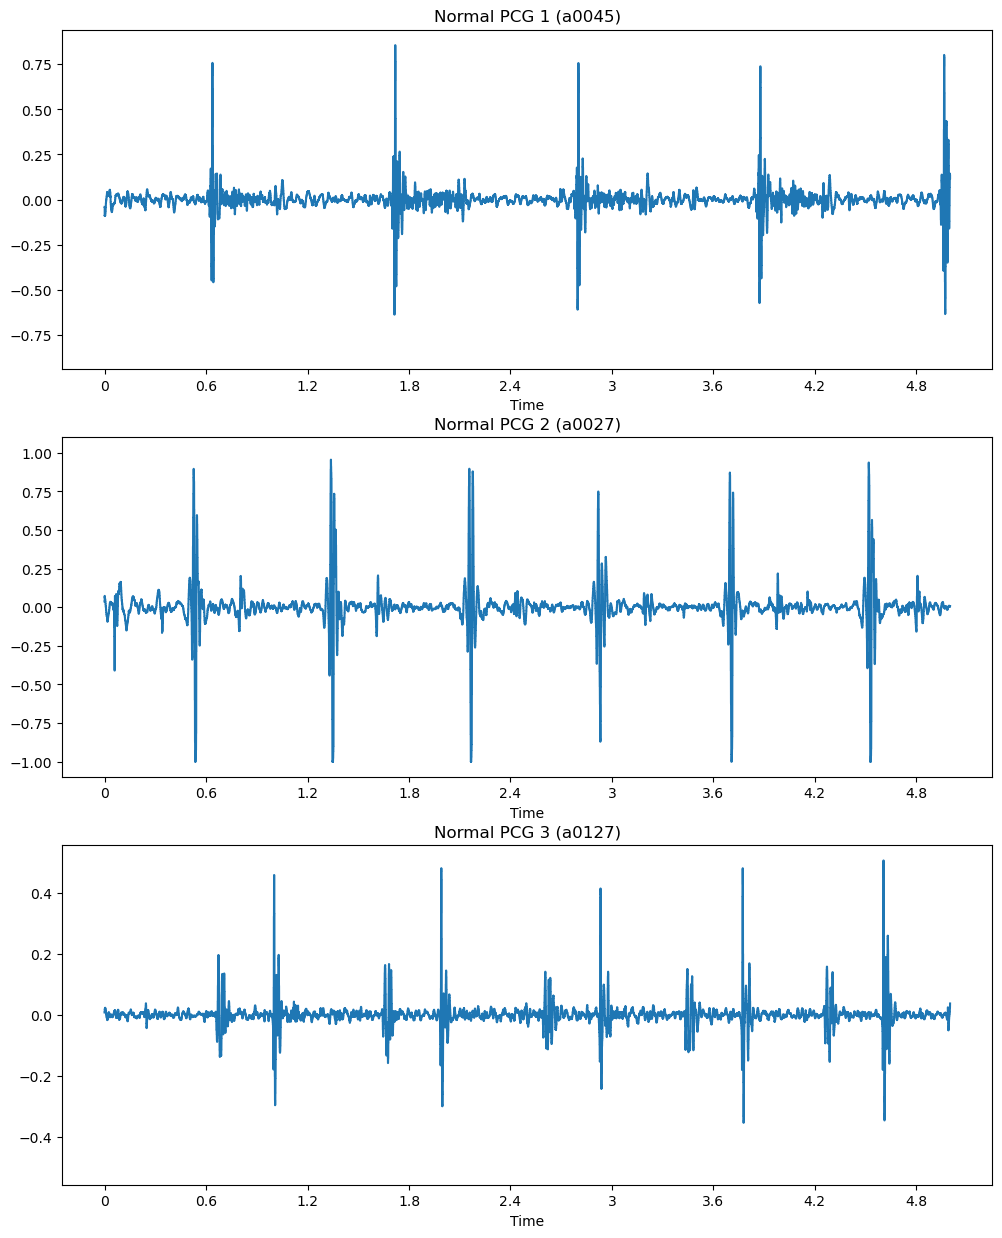

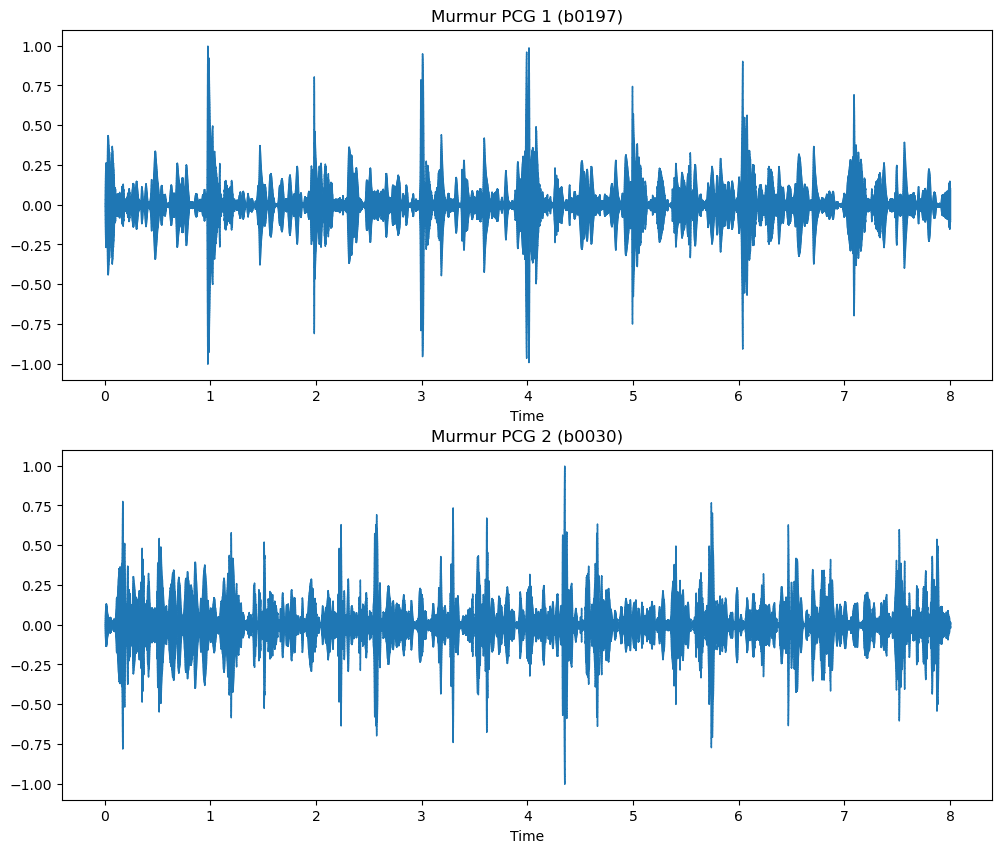

In [ ]:
# plot them
# no need to plot 30 seconds worth to be honest. reduce to 5-10 seconds
secs = 5

fig, ax = plt.subplots(nrows=3, figsize=(12, 5*3))
librosa.display.waveshow(normal_rec_1[:secs*sr_physio16],sr=sr_physio16,ax=ax[0])
ax[0].set(title='Normal PCG 1 (a0045)')
librosa.display.waveshow(normal_rec_2[:secs*sr_physio16],sr=sr_physio16,ax=ax[1])
ax[1].set(title='Normal PCG 2 (a0027)')
librosa.display.waveshow(normal_rec_3[:secs*sr_physio16],sr=sr_physio16,ax=ax[2])
ax[2].set(title='Normal PCG 3 (a0127)')
# now the murmurs
fig, ax = plt.subplots(nrows=2, figsize=(12, 5*2))
librosa.display.waveshow(murmur_rec_1,sr=sr_physio16,ax=ax[0])
ax[0].set(title='Murmur PCG 1 (b0197)')
librosa.display.waveshow(murmur_rec_2,sr=sr_physio16,ax=ax[1])
ax[1].set(title='Murmur PCG 2 (b0030)')

### 8.d.2 - Qualitative Observations on OAHS dataset

In [ ]:
joint_snr = 3
target_freq = sr_physio16 # 2khz btw

# arrays
regular_pcgs = [normal_rec_1, normal_rec_2, normal_rec_2, murmur_rec_1, murmur_rec_2]
noise_paths = get_n_random_noise_paths_han(5) # 5 real world hospital sounds

noisy_pcgs = []
for regular_pcg, noise in zip(regular_pcgs, noise_paths):
  noises, noise_sr = load_from_filepath(noise)
  # downsample to the same frequency
  noise = downsample(noise_raw, noise_sr, target_freq)
  # match lengths
  noise = match_signal_and_noise_lengths(regular_pcg, noise)
  
  composite = create_composite_at_snr(regular_pcg, noise, joint_snr) # combine the two
  composite = rescale_pcg(composite) # normalize to end
  
  # that's all
  noisy_pcgs.append(composite)

noisy_n1, noisy_n2, noisy_n3, noisy_m1, noisy_m2 = noisy_pcgs
# n1 = normal 1, m2 = murmur 2, etc

[Text(0.5, 1.0, 'Noisy n1 (a0045). SNR: 3dB')]

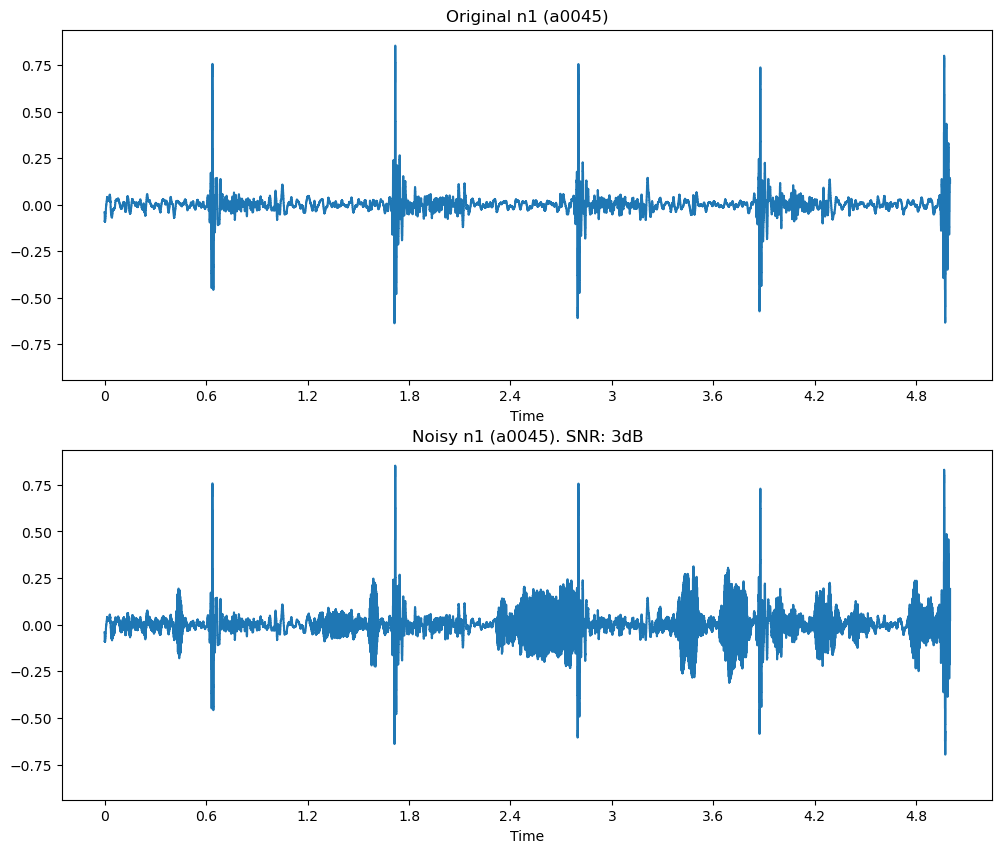

In [ ]:
# compare them
secs = 5
# plotting 
fig, ax = plt.subplots(nrows=2, figsize=(12, 5*2))
librosa.display.waveshow(normal_rec_1[:secs*sr_physio16],sr=sr_physio16,ax=ax[0])
ax[0].set(title='Original n1 (a0045)')
librosa.display.waveshow(noisy_n1[:secs*sr_physio16],sr=sr_physio16,ax=ax[1])
ax[1].set(title=f'Noisy n1 (a0045). SNR: {joint_snr}dB')

In [ ]:
# final steps: plot the model on these, then show results
model_denoised = []
segment_length = int(0.8 * sr_physio16) # seconds*sr (1600 samples here)
for noisy_rec in noisy_pcgs:
  cut_up_parts = []
  denoised_parts = []
  for i in range(0,len(noisy_rec)//segment_length):
      cut_up_parts.append(noisy_rec[i*segment_length:(i+1)*segment_length])
  with torch.no_grad():
    model.eval()
    for cut_up_part in cut_up_parts:
      cut_up_part = torch.tensor(cut_up_part, dtype=torch.float32)
      cut_up_part = cut_up_part.unsqueeze(0).unsqueeze(0).to(device) # expects (1,1,1600)
      denoised_part = model(cut_up_part)
      denoised_parts.append(denoised_part.cpu().detach().numpy()[0])
  model_denoised.append(np.concatenate(denoised_parts,axis=1)[0,:]) # remove the extra dimension
denoised_n1, denoised_n2, denoised_n3, denoised_m1, denoised_m2 = model_denoised

[Text(0.5, 1.0, 'Denoised n1 (a0045)')]

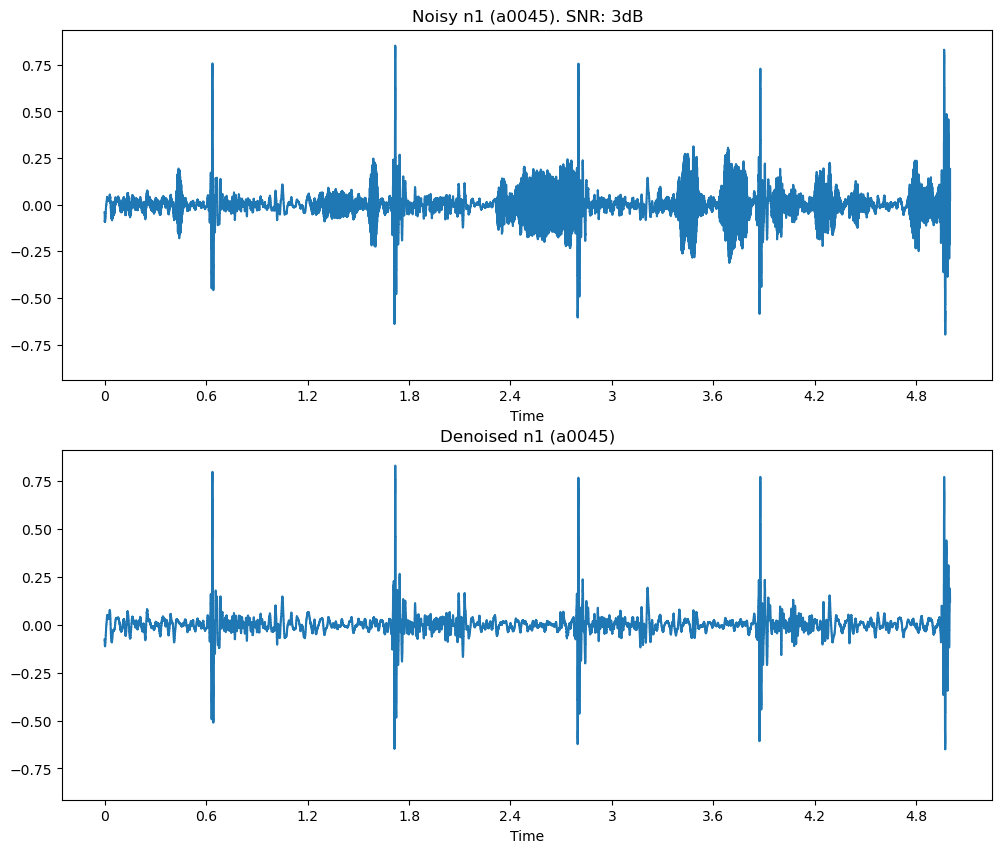

In [ ]:
# ok, this is the final product basically
fig, ax = plt.subplots(nrows=2, figsize=(12, 5*2))
librosa.display.waveshow(noisy_n1[:secs*sr_physio16],sr=sr_physio16,ax=ax[0])
ax[0].set(title=f'Noisy n1 (a0045). SNR: {joint_snr}dB')

librosa.display.waveshow(denoised_n1[:secs*sr_physio16],sr=sr_physio16,ax=ax[1])
ax[1].set(title=f'Denoised n1 (a0045)')

# wow this actually looks great

[Text(0.5, 1.0, 'Denoised n1 (a0045)')]

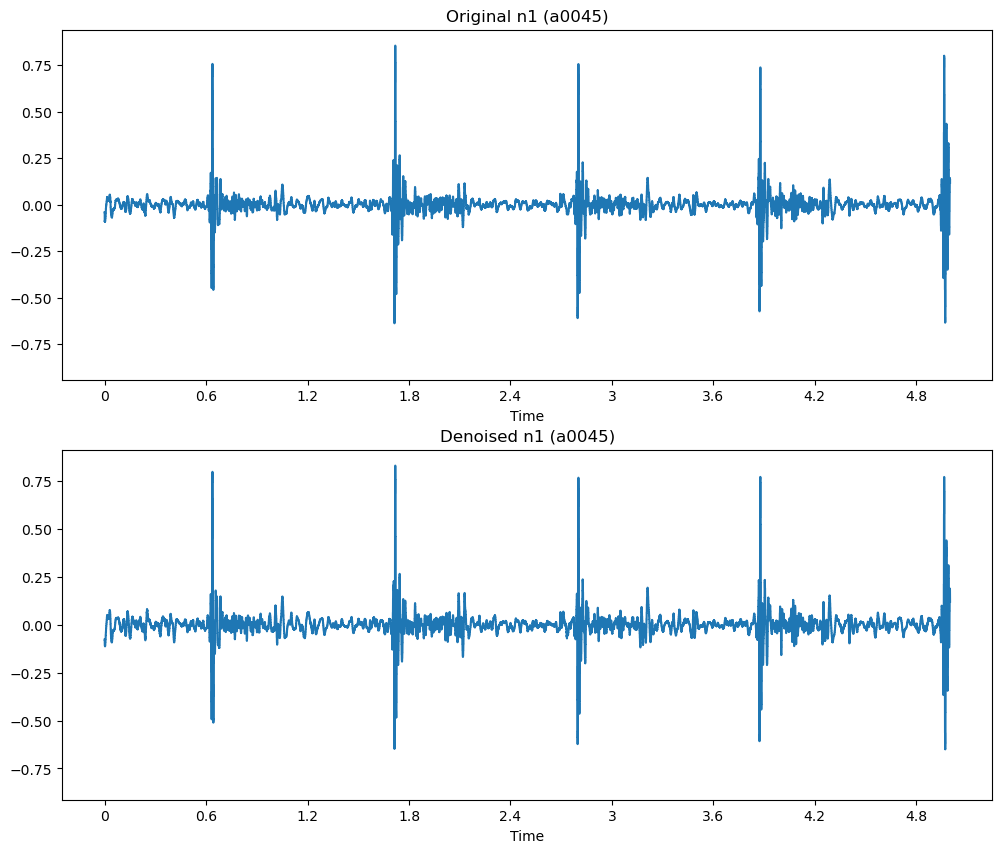

In [ ]:
# compare orig with denoised
fig, ax = plt.subplots(nrows=2, figsize=(12, 5*2))
librosa.display.waveshow(normal_rec_1[:secs*sr_physio16],sr=sr_physio16,ax=ax[0])
ax[0].set(title=f'Original n1 (a0045)')

librosa.display.waveshow(denoised_n1[:secs*sr_physio16],sr=sr_physio16,ax=ax[1])
ax[1].set(title=f'Denoised n1 (a0045)')

# wow this actually looks great

[Text(0.5, 1.0, 'Noisy m1 (b0197). SNR: 3dB')]

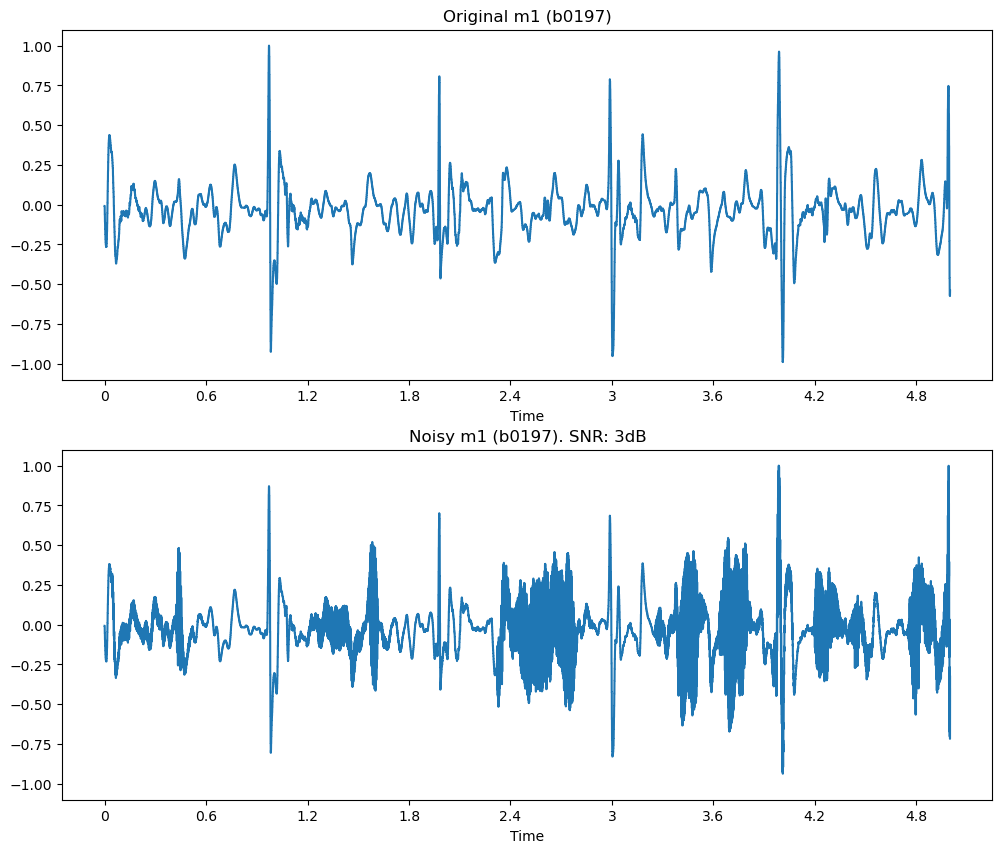

In [ ]:
# for murmurs
fig, ax = plt.subplots(nrows=2, figsize=(12, 5*2))
librosa.display.waveshow(murmur_rec_1[:secs*sr_physio16],sr=sr_physio16,ax=ax[0])
ax[0].set(title=f'Original m1 (b0197)')

librosa.display.waveshow(noisy_m1[:secs*sr_physio16],sr=sr_physio16,ax=ax[1])
ax[1].set(title=f'Noisy m1 (b0197). SNR: {joint_snr}dB')

[Text(0.5, 1.0, 'Denoised m2 (b0197)')]

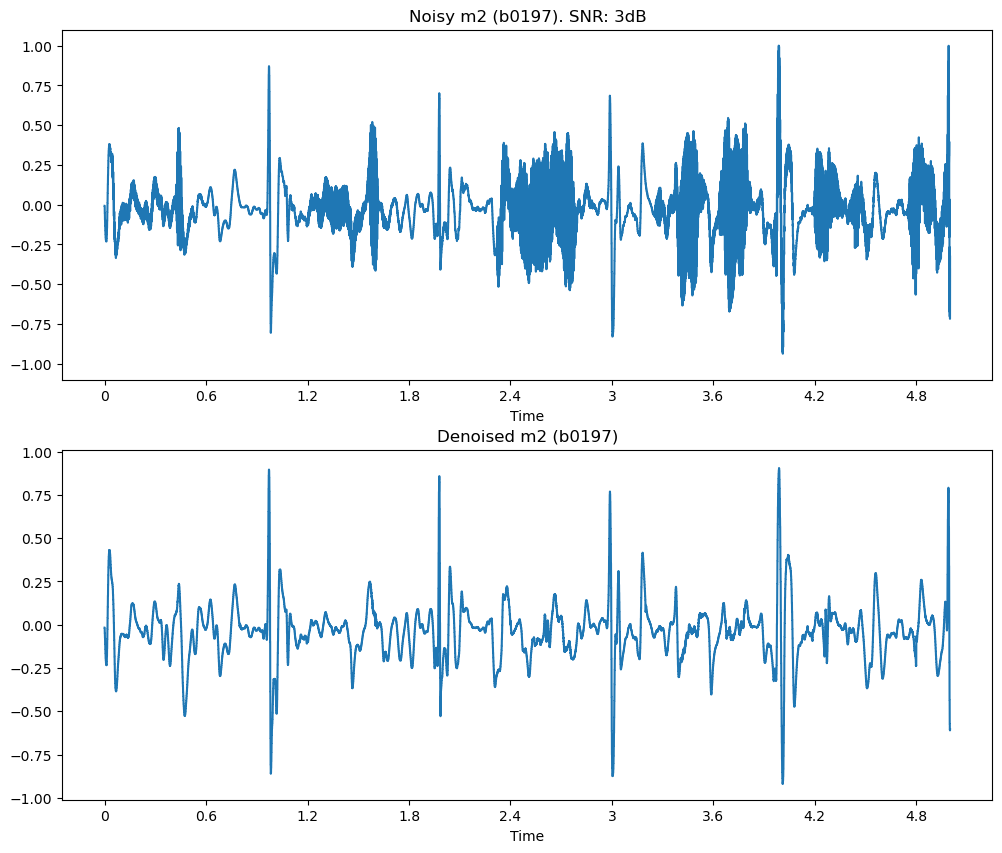

In [ ]:
# for murmur, noisy vs denoised
fig, ax = plt.subplots(nrows=2, figsize=(12, 5*2))
librosa.display.waveshow(noisy_m1[:secs*sr_physio16],sr=sr_physio16,ax=ax[0])
ax[0].set(title=f'Noisy m2 (b0197). SNR: {joint_snr}dB')

librosa.display.waveshow(denoised_m1[:secs*sr_physio16],sr=sr_physio16,ax=ax[1])
ax[1].set(title=f'Denoised m2 (b0197)')

[Text(0.5, 1.0, 'Denoised m1 (b0197)')]

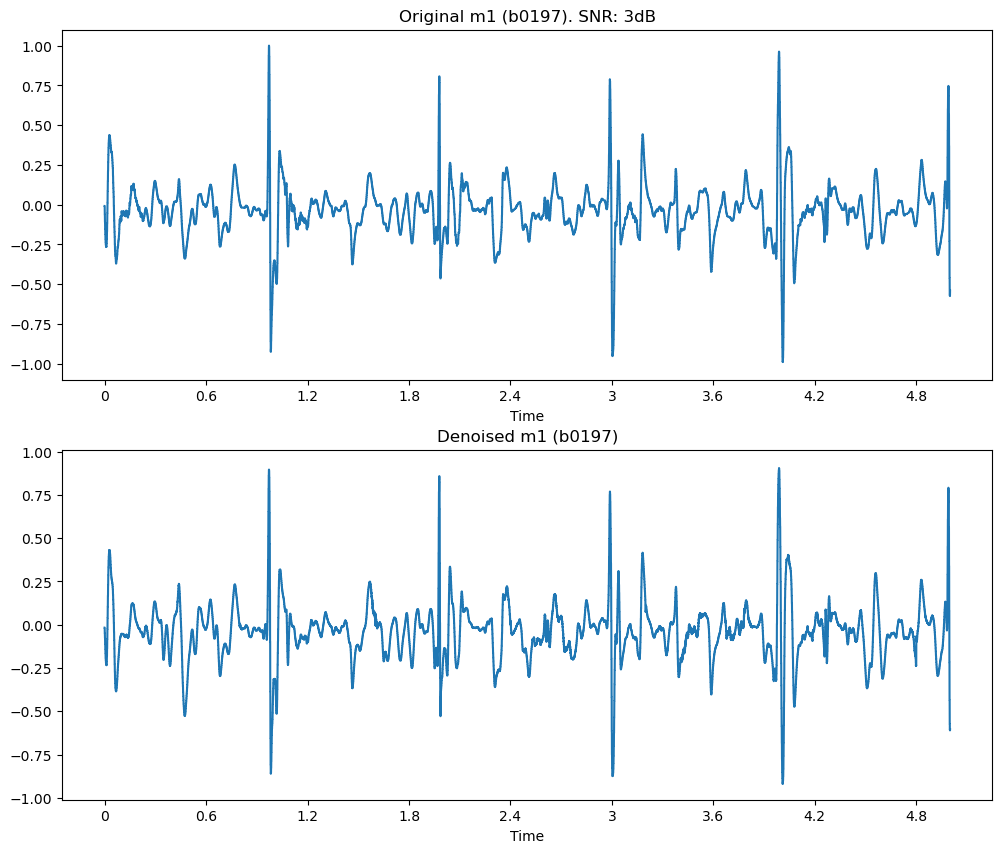

In [ ]:
# for murmur, original vs denoised
fig, ax = plt.subplots(nrows=2, figsize=(12, 5*2))
librosa.display.waveshow(murmur_rec_1[:secs*sr_physio16],sr=sr_physio16,ax=ax[0])
ax[0].set(title=f'Original m1 (b0197). SNR: {joint_snr}dB')


librosa.display.waveshow(denoised_m1[:secs*sr_physio16],sr=sr_physio16,ax=ax[1])
ax[1].set(title=f'Denoised m1 (b0197)')

## 9. Appendix

In [ ]:
# amount of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {total_params}")

Model parameters: 8049953
